In [1]:
# Do this first. It's going to take a while
!pip install pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()
df = spark.read.csv('socialmedia.csv',header=True,escape="\"")
df.show(10,0)

+------------------+---+------+-----------------+------------------+-----------+----------------+-----------------------------------------------------------------+---------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|Timestamp         |Age|Gender|Relationship     |Occupation        |Affiliation|Social_Media_Use|Platforms_Used                                                   |Time_on_SM           |SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|
+------------------+---+------+-----------------+------------------+-----------+----------------+-----------------------------------------------------------------+---------

In [3]:
# prompt: select Occupation="University Student" from df

df.filter((df.Occupation == "University Student") & (df.Social_Media_Use == "Yes")).show()


+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|         Timestamp|Age|Gender|     Relationship|        Occupation|       Affiliation|Social_Media_Use|      Platforms_Used|          Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|
+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+----------------

In [4]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
# Map string categories to numerical values
df = df.withColumn("Time_on_SM_Numeric",
                   when(col("Time_on_SM") == "Less than an Hour", 0.5) \
                   .when(col("Time_on_SM") == "Between 1 and 2 hours", 1.5) \
                   .when(col("Time_on_SM") == "Between 2 and 3 hours", 2.5) \
                   .when(col("Time_on_SM") == "Between 3 and 4 hours", 3.5) \
                   .when(col("Time_on_SM") == "Between 4 and 5 hours", 4.5) \
                   .when(col("Time_on_SM") == "More than 5 hours", 5.5) \
                   # Add more conditions as needed based on your categories
                   .otherwise(None)) # Handle cases not covered by your mapping

# Assemble features into a vector using the new numerical column
assembler = VectorAssembler(inputCols=["Time_on_SM_Numeric"], outputCol="features")
df = assembler.transform(df)

In [ ]:
df.show();

+------------------+---+------+-----------------+------------------+-----------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+------------------+--------+
|         Timestamp|Age|Gender|     Relationship|        Occupation|Affiliation|Social_Media_Use|      Platforms_Used|          Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|Time_on_SM_Numeric|features|
+------------------+---+------+-----------------+------------------+-----------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------

In [5]:
from pyspark.sql.functions import col, isnan, when, count

# Count null values for each column, excluding '_id' and vector columns
df.select([count(when(col(c).isNull(), c)).alias(c)
           for c in df.columns if c not in ['_id', 'features']]).show()

+---------+---+------+------------+----------+-----------+----------------+--------------+----------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+------------------+
|Timestamp|Age|Gender|Relationship|Occupation|Affiliation|Social_Media_Use|Platforms_Used|Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|Time_on_SM_Numeric|
+---------+---+------+------------+----------+-----------+----------------+--------------+----------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+-------

In [6]:
# prompt: correlation of Time_on_SM_Numeric with Depression_Frequency

from pyspark.sql.functions import corr
df.select(corr("Time_on_SM_Numeric","Depression_Frequency")).show();

+----------------------------------------------+
|corr(Time_on_SM_Numeric, Depression_Frequency)|
+----------------------------------------------+
|                            0.3304888214821369|
+----------------------------------------------+



In [7]:
# prompt: Correlation between Time_on_SM_Numeric and Depression_Frequency

df.select(corr("Time_on_SM_Numeric","Restlessness_Without_SM")).show();


+-------------------------------------------------+
|corr(Time_on_SM_Numeric, Restlessness_Without_SM)|
+-------------------------------------------------+
|                               0.4000580835246064|
+-------------------------------------------------+



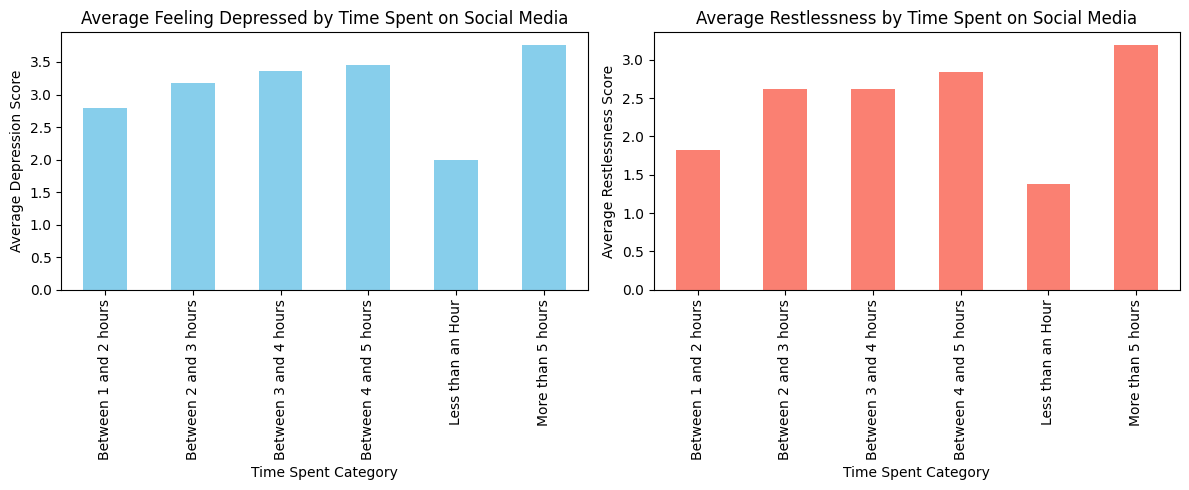

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Convert 'Depression_Frequency' and 'Restlessness_Without_SM' to numeric, handling errors
pandas_df['Depression_Frequency'] = pd.to_numeric(pandas_df['Depression_Frequency'], errors='coerce')
pandas_df['Restlessness_Without_SM'] = pd.to_numeric(pandas_df['Restlessness_Without_SM'], errors='coerce')

# Calculate mean depression and restlessness scores for each category
mean_depression = pandas_df.groupby('Time_on_SM')['Depression_Frequency'].mean()
mean_restlessness = pandas_df.groupby('Time_on_SM')['Restlessness_Without_SM'].mean()

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Depression plot
mean_depression.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Average Feeling Depressed by Time Spent on Social Media')
axes[0].set_xlabel('Time Spent Category')
axes[0].set_ylabel('Average Depression Score')

# Restlessness plot
mean_restlessness.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Average Restlessness by Time Spent on Social Media')
axes[1].set_xlabel('Time Spent Category')
axes[1].set_ylabel('Average Restlessness Score')

plt.tight_layout()
plt.show()

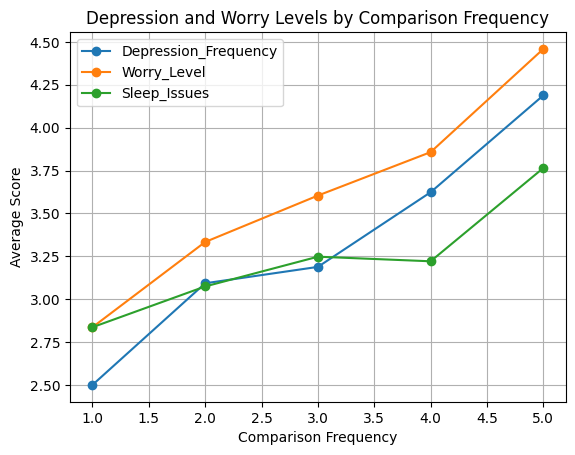

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Convert 'Depression_Frequency', 'Worry_Level' and 'Comparison_Frequency' to numeric, handling errors
pandas_df['Depression_Frequency'] = pd.to_numeric(pandas_df['Depression_Frequency'], errors='coerce')
pandas_df['Worry_Level'] = pd.to_numeric(pandas_df['Worry_Level'], errors='coerce')
pandas_df['Sleep_Issues'] = pd.to_numeric(pandas_df['Sleep_Issues'], errors='coerce')
pandas_df['Comparison_Frequency'] = pd.to_numeric(pandas_df['Comparison_Frequency'], errors='coerce') # Ensure this column is also numeric for grouping

# Group the Pandas DataFrame by 'Comparison_Frequency' and calculate the mean of 'Depression_Frequency' and 'Worry_Level'
grouped = pandas_df.groupby('Comparison_Frequency')[['Depression_Frequency', 'Worry_Level', 'Sleep_Issues']].mean()

# Plot the line graph
grouped.plot(kind='line', marker='o')
plt.title('Depression and Worry Levels by Comparison Frequency')
plt.xlabel('Comparison Frequency')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

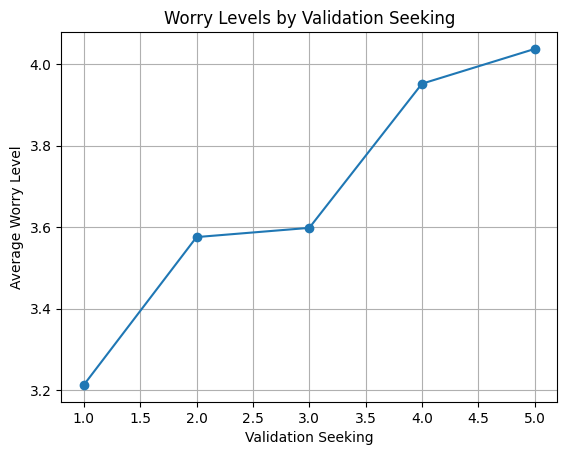

In [ ]:
# prompt: line graph of Worry_Level and Validation_Seeking

import pandas as pd
import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Convert 'Worry_Level' and 'Validation_Seeking' to numeric, handling errors
pandas_df['Worry_Level'] = pd.to_numeric(pandas_df['Worry_Level'], errors='coerce')
pandas_df['Validation_Seeking'] = pd.to_numeric(pandas_df['Validation_Seeking'], errors='coerce')

# Group the Pandas DataFrame by 'Validation_Seeking' and calculate the mean of 'Worry_Level'
grouped = pandas_df.groupby('Validation_Seeking')['Worry_Level'].mean()

# Plot the line graph
grouped.plot(kind='line', marker='o')
plt.title('Worry Levels by Validation Seeking')
plt.xlabel('Validation Seeking')
plt.ylabel('Average Worry Level')
plt.grid(True)
plt.show()


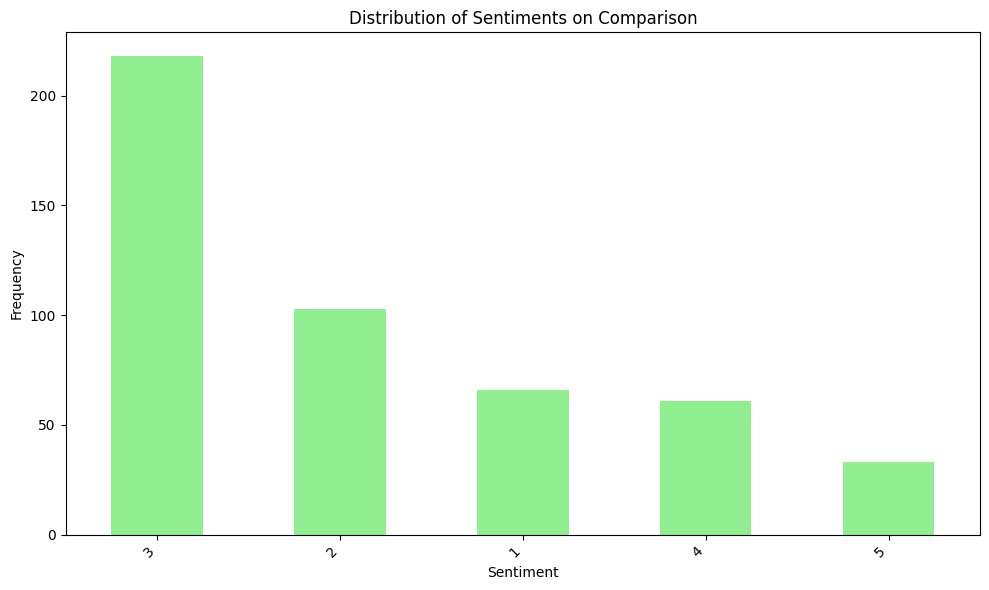

In [ ]:
# prompt: sentiment distribution chart for comparison feelings

import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Count the frequency of each sentiment in 'Comparison_Feelings'
sentiment_counts = pandas_df['Comparison_Feelings'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Sentiments on Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
heatmap of

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

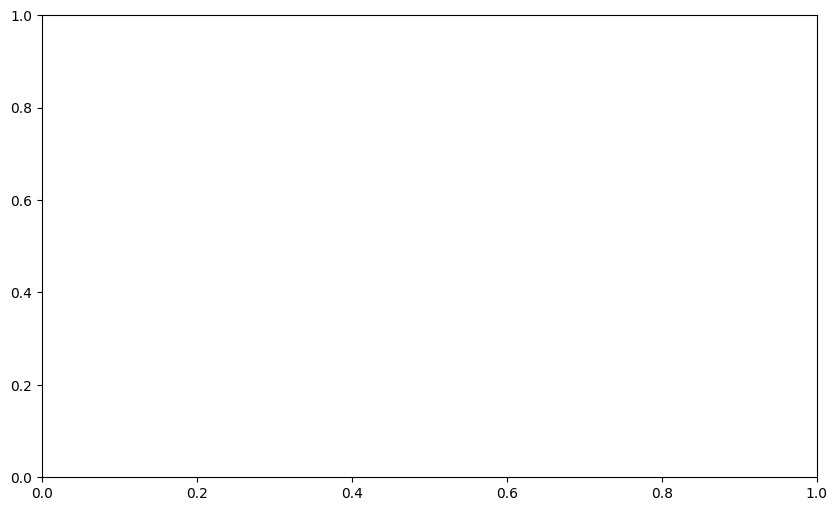

In [ ]:
# prompt: box plots for Age and Time_on_SM

import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Extract the relevant columns
age_data = pandas_df['Age']
time_on_sm_data = pandas_df['Time_on_SM']

# Create the box plots
plt.figure(figsize=(10, 6))
plt.boxplot([age_data, time_on_sm_data.dropna().replace({
    'Less than an Hour': 1,
    'Between 1 and 2 hours': 2,
    'Between 2 and 3 hours': 3,
    'Between 3 and 4 hours': 4,
    'Between 4 and 5 hours': 5,
    'More than 5 hours': 6
})], labels=['Age', 'Time on Social Media (Encoded)'])
plt.title('Box Plots for Age and Time Spent on Social Media')
plt.ylabel('Value')
plt.show()


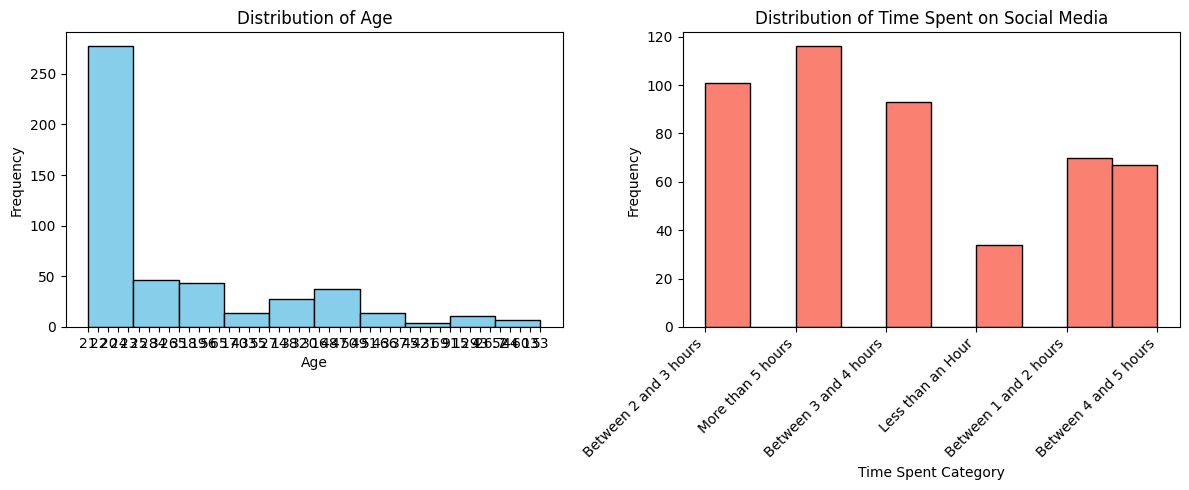

In [ ]:
# prompt: Histograms for Age and Time_on_SM

import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age histogram
axes[0].hist(pandas_df['Age'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Time on Social Media histogram
axes[1].hist(pandas_df['Time_on_SM'], bins=10, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Time Spent on Social Media')
axes[1].set_xlabel('Time Spent Category')
axes[1].set_ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


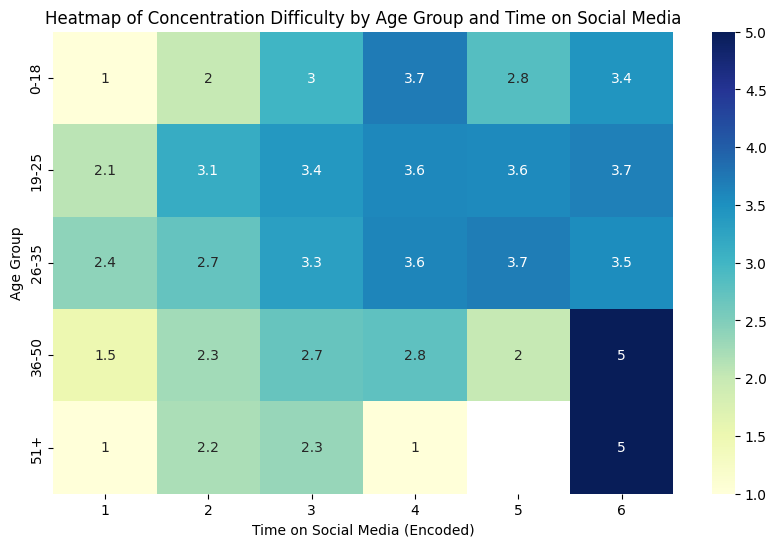

In [15]:
# prompt: heat map of Concentration_Difficulty based on AgeGroup and Time_on_SMConcentration_Difficulty based on Age and Time_on_SM

import pandas as pd
import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Convert 'Age' column to numeric, handling non-numeric values as NaN
pandas_df['Age'] = pd.to_numeric(pandas_df['Age'], errors='coerce')

# Create AgeGroup column
pandas_df['AgeGroup'] = pd.cut(pandas_df['Age'], bins=[0, 18, 25, 35, 50, 100],
                               labels=['0-18', '19-25', '26-35', '36-50', '51+'])

# Convert 'Time_on_SM' and 'Concentration_Difficulty' to numeric, handling errors
pandas_df['Concentration_Difficulty'] = pd.to_numeric(pandas_df['Concentration_Difficulty'], errors='coerce')
time_on_sm_mapping = {
    'Less than an Hour': 1,
    'Between 1 and 2 hours': 2,
    'Between 2 and 3 hours': 3,
    'Between 3 and 4 hours': 4,
    'Between 4 and 5 hours': 5,
    'More than 5 hours': 6
}
pandas_df['Time_on_SM_Numeric'] = pandas_df['Time_on_SM'].map(time_on_sm_mapping)

# Create pivot table for heatmap
heatmap_data = pandas_df.pivot_table(index='AgeGroup', columns='Time_on_SM_Numeric', values='Concentration_Difficulty', aggfunc='mean')

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Concentration Difficulty by Age Group and Time on Social Media')
plt.xlabel('Time on Social Media (Encoded)')
plt.ylabel('Age Group')
plt.show()

In [16]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "AgeGroup",
    when(col("Age").between(13, 18), "Adolescents (13-18)")
    .when(col("Age").between(19, 29), "Young Adults (19-29)")
    .when(col("Age").between(30, 39), "Adults (30-39)")
    .when(col("Age").between(40, 49), "Middle-Aged Adults (40-49)")
    .when(col("Age").between(50, 59), "Older Adults (50-59)")
    .when(col("Age").between(60, 69), "Seniors (60-69)")
)

# Show the resulting DataFrame
df.show(482)

+------------------+----+-------------------+-----------------+------------------+--------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+------------------+--------+--------------------+
|         Timestamp| Age|             Gender|     Relationship|        Occupation|         Affiliation|Social_Media_Use|      Platforms_Used|          Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|Time_on_SM_Numeric|features|            AgeGroup|
+------------------+----+-------------------+-----------------+------------------+--------------------+----------------+

<ipython-input-17-25345d8a12a5>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pandas_df.groupby('AgeGroup')['Time_on_SM_Numeric'].mean()


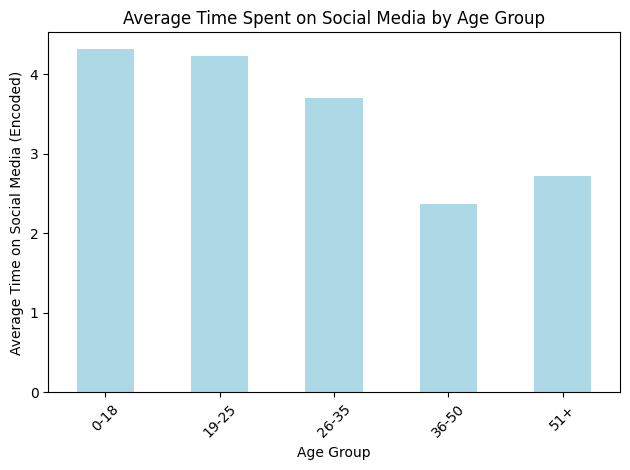

In [17]:
# prompt: Barchart for average Time_on_SM based on age group

import matplotlib.pyplot as plt
# Group the Pandas DataFrame by 'AgeGroup' and calculate the mean of 'Time_on_SM_Numeric'
grouped = pandas_df.groupby('AgeGroup')['Time_on_SM_Numeric'].mean()

# Plot the bar chart
grouped.plot(kind='bar', color='lightblue')
plt.title('Average Time Spent on Social Media by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Time on Social Media (Encoded)')
plt.xticks(rotation=45)  # Keep x-axis labels horizontal for clarity
plt.tight_layout()
plt.show()


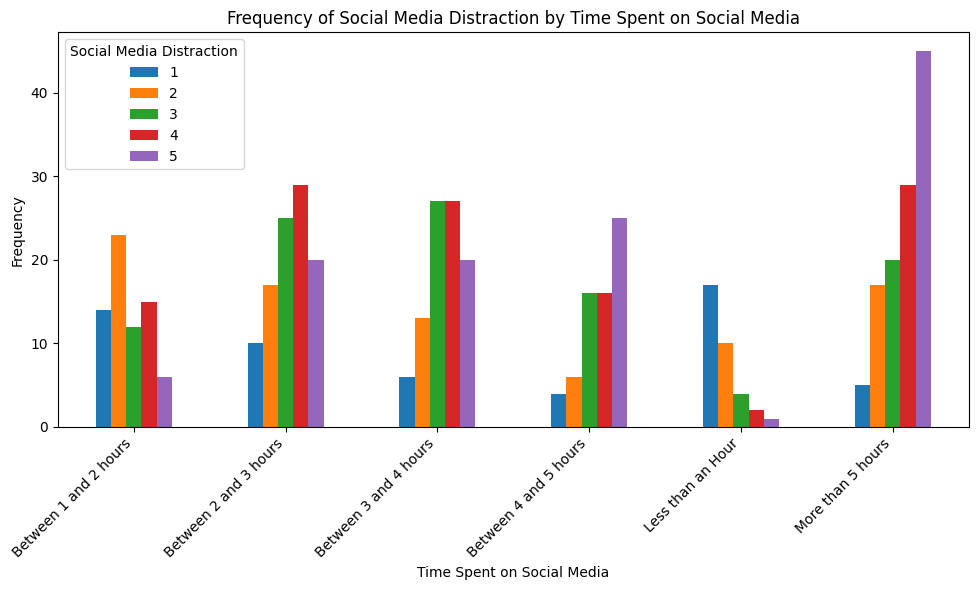

In [18]:
# prompt: Barchart for frequency of SM_Distraction based on Time_on_SM

import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Group the data by 'Time_on_SM' and count the frequency of each 'SM_Distraction' category
grouped_data = pandas_df.groupby('Time_on_SM')['SM_Distraction'].value_counts().unstack().fillna(0)

# Plot the bar chart
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Frequency of Social Media Distraction by Time Spent on Social Media')
plt.xlabel('Time Spent on Social Media')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Social Media Distraction', loc='upper left')
plt.tight_layout()
plt.show()


In [31]:
# prompt: Box Plot for frequency of SM_Distraction based on Time_on_SM

import matplotlib.pyplot as plt
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Create a mapping for 'Time_on_SM' to numerical values for plotting
time_on_sm_mapping = {
    'Less than an Hour': 1,
    'Between 1 and 2 hours': 2,
    'Between 2 and 3 hours': 3,
    'Between 3 and 4 hours': 4,
    'Between 4 and 5 hours': 5,
    'More than 5 hours': 6
}
pandas_df['Time_on_SM_Numeric'] = pandas_df['Time_on_SM'].map(time_on_sm_mapping)

# Group the data by 'Time_on_SM_Numeric' and count the frequency of 'SM_Distraction'
grouped_data = pandas_df.groupby('Time_on_SM_Numeric')['SM_Distraction'].value_counts().unstack().fillna(0)

# Convert the values in grouped_data to numeric type
grouped_data = grouped_data.astype(float)

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data.values, labels=grouped_data.index) # Pass the numeric values to boxplot
plt.title('Frequency of Social Media Distraction by Time Spent on Social Media')
plt.xlabel('Time Spent on Social Media (Encoded)')
plt.ylabel('Frequency of Social Media Distraction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'Time_on_SM_Numeric' is not defined

<Figure size 1000x600 with 0 Axes>

+-----------------+--------------+-----+
|Easily_Distracted|SM_Distraction|count|
+-----------------+--------------+-----+
|                4|             2|    8|
|                4|             1|    1|
|                5|             4|   24|
|                5|             1|    2|
|                5|             5|   58|
|                1|             1|   21|
|                2|             3|   15|
|                4|             4|   45|
|                3|             3|   56|
|                2|             2|   31|
|                1|             2|    8|
|                5|             2|    6|
|                2|             4|    7|
|                5|             3|   11|
|                1|             5|    2|
|                3|             1|   13|
|                1|             3|    2|
|                3|             5|   17|
|                3|             2|   33|
|                3|             4|   42|
+-----------------+--------------+-----+
only showing top

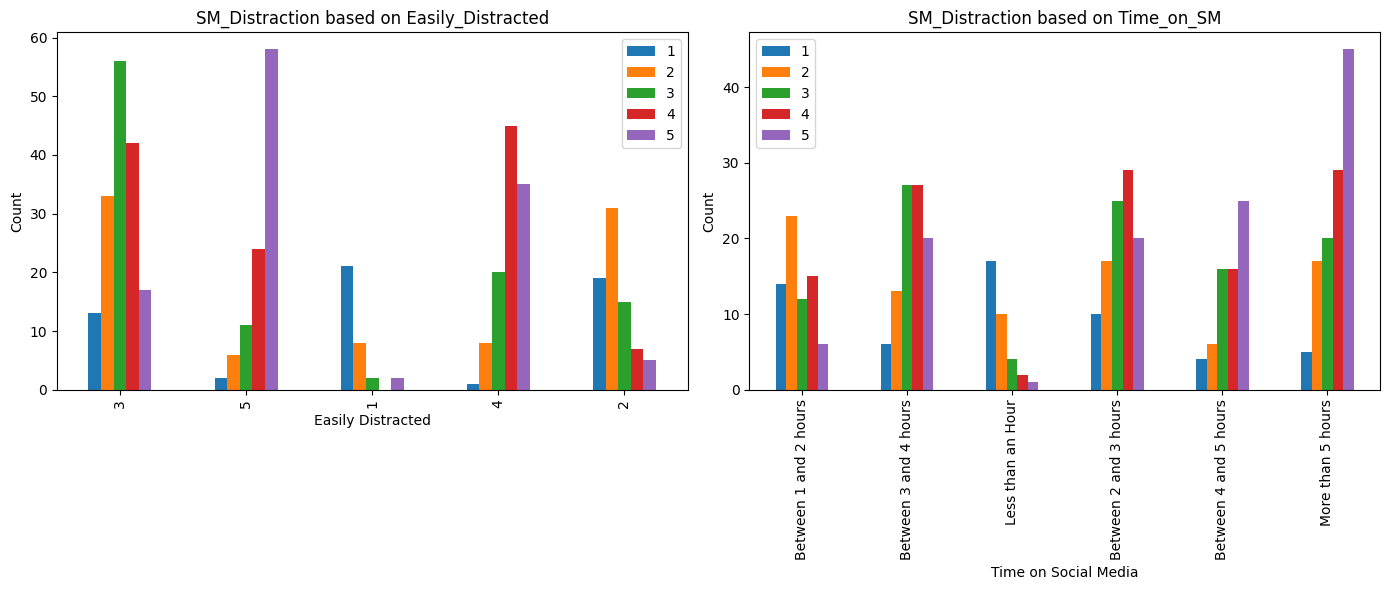

In [26]:
# prompt: SM_Distraction based on Easily_Distracted Vs SM_Distraction based on Time_on_SM

import matplotlib.pyplot as plt
# Group by 'Easily_Distracted' and count the frequency of each 'SM_Distraction' category
distraction_by_easily_distracted = df.groupBy('Easily_Distracted', 'SM_Distraction').count()

# Show the result
distraction_by_easily_distracted.show()

# Pivot the data for plotting
pivot_easily_distracted = distraction_by_easily_distracted.groupBy('Easily_Distracted').pivot('SM_Distraction').sum('count')
# Group by 'Time_on_SM' and count the frequency of each 'SM_Distraction' category before pivoting
distraction_counts = df.groupBy('Time_on_SM', 'SM_Distraction').count()
pivot_time_on_sm = distraction_counts.groupBy('Time_on_SM').pivot('SM_Distraction').sum('count') # Use df instead of distraction_counts

# Convert to Pandas for plotting
pandas_df_easily_distracted = pivot_easily_distracted.toPandas()
pandas_df_time_on_sm = pivot_time_on_sm.toPandas()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Easily Distracted
pandas_df_easily_distracted.set_index('Easily_Distracted').plot(kind='bar', ax=axes[0])
axes[0].set_title('SM_Distraction based on Easily_Distracted')
axes[0].set_xlabel('Easily Distracted')
axes[0].set_ylabel('Count')

# Time on SM
pandas_df_time_on_sm.set_index('Time_on_SM').plot(kind='bar', ax=axes[1])
axes[1].set_title('SM_Distraction based on Time_on_SM')
axes[1].set_xlabel('Time on Social Media')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

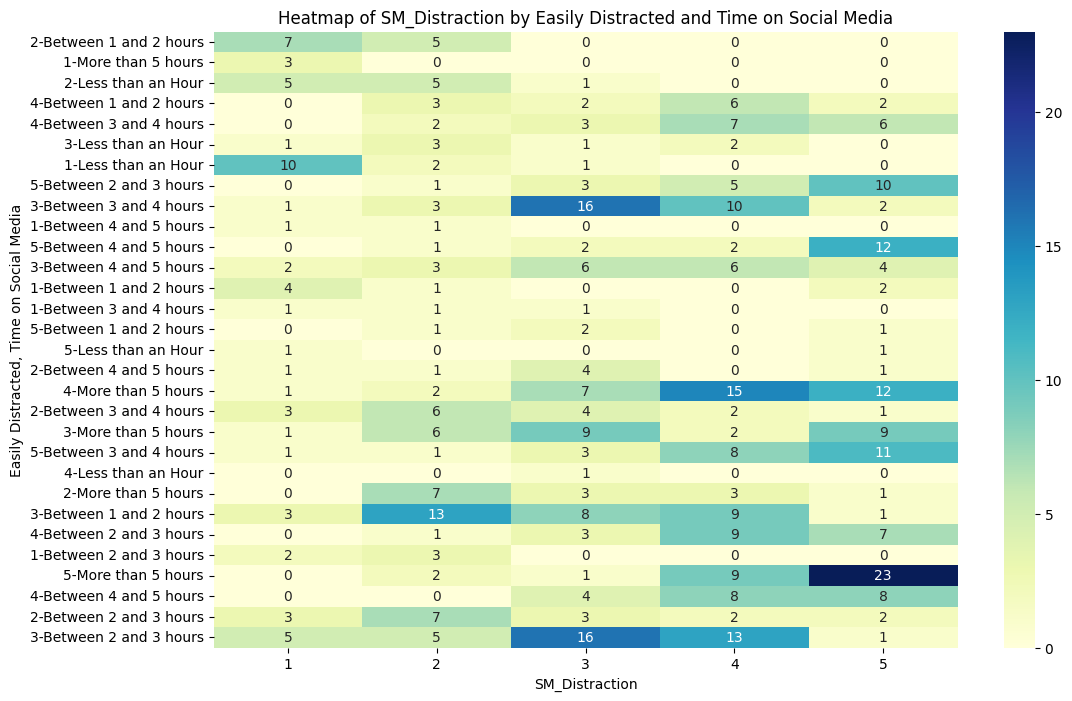

In [27]:
# prompt: heat map for average SM_distraction based on Easily_Distracted and Time_on_SM

import matplotlib.pyplot as plt
# Group by 'Easily_Distracted' and 'Time_on_SM', calculate average 'SM_Distraction'
heatmap_data = df.groupBy('Easily_Distracted', 'Time_on_SM').avg('SM_Distraction').toPandas()

# Pivot the data for heatmap
heatmap_data = heatmap_data.pivot(index='Easily_Distracted', columns='Time_on_SM', values='avg(SM_Distraction)')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Average SM_Distraction by Easily Distracted and Time on Social Media')
plt.xlabel('Time on Social Media')
plt.ylabel('Easily Distracted')
plt.show()
